# Adam Optimizer - Pytorch (From Scratch)

In [1]:
import torch
from torch import nn
from torchvision import datasets
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu' # will select 'cuda' is gpu is available otherwise 'cpu'
print('Chosen device:', device)

Chosen device: cuda


## Getting our dataset

In [2]:
# transform = lambda image: torch.FloatTensor(image.getdata())/255.0
# or 
def transform(image):
    return torch.FloatTensor(image.getdata())/255.0

train_mnist = datasets.FashionMNIST(root = '~/data', train = True, transform = transform, download = True)
test_mnist = datasets.FashionMNIST(root = '~/data', train = False, transform = transform, download = True)

In [3]:
image, label = train_mnist[0]
print(image.shape, label)

torch.Size([784]) 9


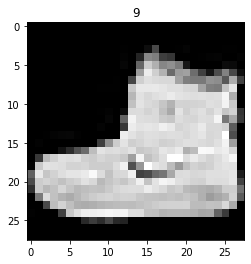

In [4]:
plt.imshow(image.reshape(28, 28), cmap = 'gray')
plt.title(label)
plt.show()

## Creating data loader for training and testing

In [5]:
batch_size = 64
train_data = torch.utils.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
test_data = torch.utils.data.DataLoader(test_mnist, batch_size = batch_size, shuffle = False)

print('No of batches for batch size {} is {}'.format(batch_size, len(train_data)))

No of batches for batch size 64 is 938


## Building the model

In [7]:
W1 = nn.Parameter(torch.normal(0, 0.1, [784, 256], device = device))
b1 = nn.Parameter(torch.normal(0, 0.1, [256], device = device))

W2 = nn.Parameter(torch.normal(0, 0.1, [256, 128], device = device))
b2 = nn.Parameter(torch.normal(0, 0.1, [128], device = device))

W3 = nn.Parameter(torch.normal(0, 0.1, [128, 10], device = device))
b3 = nn.Parameter(torch.normal(0, 0.1, [10], device = device))

params = [W1, b1, W2, b2, W3, b3]

with torch.no_grad():
    vs = []
    sqrs = []
    for param in params:
        vs.append(torch.zeros_like(param) + 1e-8)
        sqrs.append(torch.zeros_like(param) + 1e-8)

def relu(linear):
    linear[linear > 0] = 1
    return linear

def softmax(linear):
    exp = torch.exp(linear - torch.max(linear, axis = 1)[0].reshape(-1, 1))
    # subtracting max for numerical statbility... (it does not affect the outputs)
    norms = torch.sum(exp, axis = 1).reshape(-1, 1)
    return exp / norms

def neuralnetworks(inputs):
    layer1 = relu(torch.mm(inputs, W1) + b1)
    layer2 = relu(torch.mm(layer1, W2) + b2)
    return softmax(torch.mm(layer2, W3) + b3)

## Defining our objective function

In [8]:
def categoricalcrossentropy(predictions, labels):
    return -torch.sum(labels * torch.log(predictions))

## Defining Adam Optimizer

In [9]:
def adam(t, params = params, vs = vs, sqrs = sqrs, lr = 0.001):
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-6

    with torch.no_grad():
        # doing all the parameter updated inside torch.no_grad, because we don't want to record any computation of sgd for backward pass....
        for i in range(len(params)):
            grads = params[i].grad / batch_size

            vs[i] = beta1 * vs[i] + (1.0 - beta1) * grads
            sqrs[i] = beta2 * sqrs[i] + (1.0 - beta2) * torch.pow(grads, 2)

            v_bias_corr = vs[i] / (1. - beta1 ** t)
            sqr_bias_corr = sqrs[i] / (1. - beta2 ** t)
            
            params[i] -= lr * v_bias_corr / (torch.sqrt(sqr_bias_corr) + eps)

            params[i].grad.zero_()
            # zeroing the gradient of after each update so that it would't affect the gradients of for the next update

## Defining our accuracy function

In [10]:
def accuracy(predictions, labels):
    return (predictions.argmax(1) == labels.argmax(1)).float().mean()

## Training the  model

In [11]:
import torch.nn.functional as F

def onehot(label):
    return F.one_hot(label, 10).float()

In [12]:
epochs = 10
num_batches = len(train_data)
learning_rate = .001
losses = []
accs = []
t = 0

for epoch in range(epochs):
    cumulative_loss = 0
    cumulative_acc = 0
    
    for features, labels in train_data:
        t += 1

        features = features.to(device) # .to(device) put features stored in cpu to device(which we have initialized above)
        labels = onehot(labels.to(device)) # .to(device) put labels stored in cpu to device(which we have initialized above)
        
        output = neuralnetworks(features)
        loss = categoricalcrossentropy(output, labels)
        loss.backward()
        
        adam(t, params, lr = learning_rate) # RUNNING ADAM OPTIMIZER

        with torch.no_grad():
            cumulative_loss += loss
            cumulative_acc += accuracy(output, labels)
    
    loss = cumulative_loss/num_batches
    acc = cumulative_acc/num_batches
    
    losses.append(loss)
    accs.append(acc)
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.5f}')

Epoch: 0 | Loss: 31.93414 | Accuracy: 0.82048
Epoch: 1 | Loss: 23.68109 | Accuracy: 0.86407
Epoch: 2 | Loss: 21.58989 | Accuracy: 0.87460
Epoch: 3 | Loss: 20.19484 | Accuracy: 0.88155
Epoch: 4 | Loss: 19.04021 | Accuracy: 0.88799
Epoch: 5 | Loss: 18.24604 | Accuracy: 0.89307
Epoch: 6 | Loss: 17.65062 | Accuracy: 0.89522
Epoch: 7 | Loss: 16.79852 | Accuracy: 0.90005
Epoch: 8 | Loss: 16.32783 | Accuracy: 0.90323
Epoch: 9 | Loss: 15.73791 | Accuracy: 0.90542


## Lets see test accuracy

In [16]:
acc = 0.0
test_batches = len(test_data)
for features, labels in test_data:
    features = features.to(device) # .to(device) put features stored in cpu to device(which we have initialized above)
    labels = onehot(labels.to(device)) # .to(device) put labels stored in cpu to device(which we have initialized above)
    outputs = neuralnetworks(features)
    acc += accuracy(outputs, labels)
    
print(f'Test Accuracy: {acc/test_batches}')

Test Accuracy: 0.8755971193313599


In [17]:
def plot(losses = losses, accs = accs, model = neuralnetworks):
    samples = 16
    plt.plot(losses, 'r')
    plt.title('Loss during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(accs, 'g')
    plt.title('Accuracy during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure(figsize = (15, 15))

    for i, example in enumerate(test_mnist, 1):
        features = example[0].to(device).reshape(1, -1)
        labels = example[1]
        outputs = model(features).argmax(1)
        plt.subplot(4, 4, i)
        plt.imshow(features[0].cpu().reshape(28, 28), cmap = 'gray')
        plt.axis('off')
        plt.title(f'Predicted: {outputs.item()}, Target: {labels}')
        if i == samples:
            break
    plt.show()

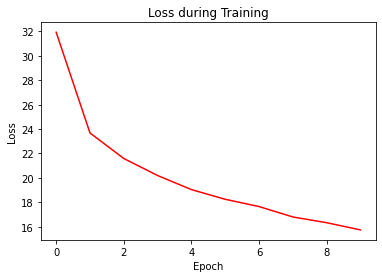

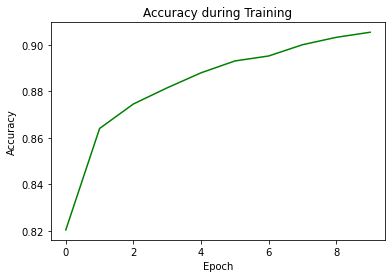

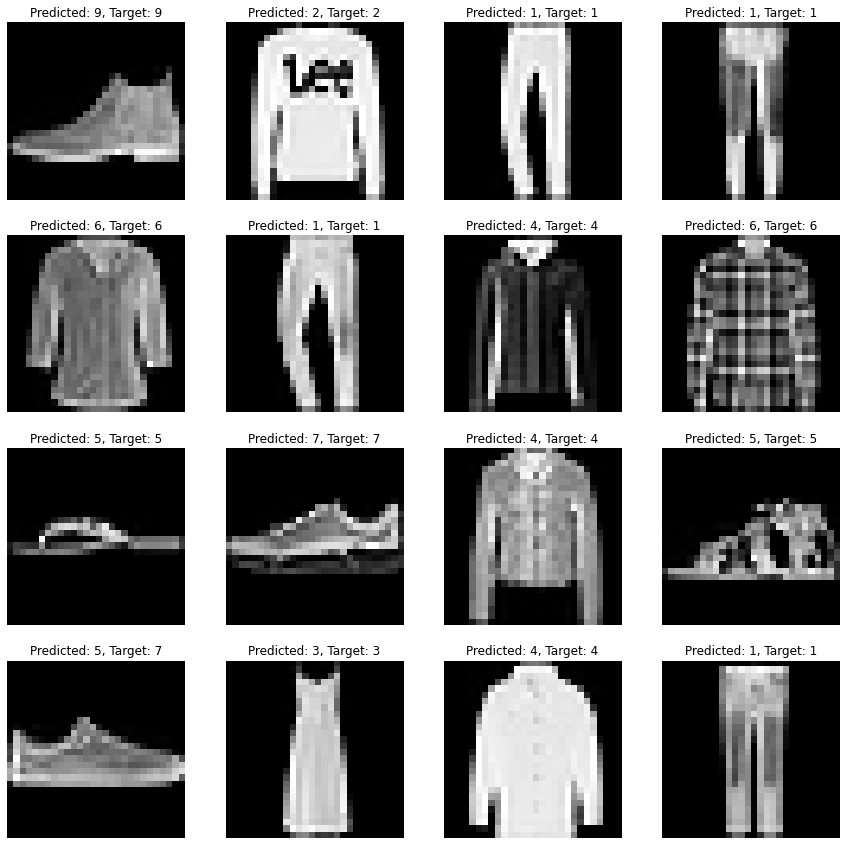

In [18]:
plot()